# Modeling - Housing Price Prediction

## By: Nick Roller

## 1. Problem Statement:

Our client has asked us to produce a model to predict the expected price of a home given it's features, ammenities and attributes. As our dependant variable is continuous (dollar amount of home value) this will be a regression model. We will be exploring the following regression models, applying them to our dataset and determining the one that best suits our client's needs:
- Linear Regression
- Random Forest Regression
- Ridge Regression
- Lasso Regression

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
pd.set_option('display.max_rows', 500)

We first load our preprocessed data. As we can see, we have already one-hot encoded the categorical variables and scaled all continuous ones.

In [3]:
df = pd.read_csv('Data Files/data_preprocessed.csv')
df.head()

,SalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,208500,65.0,8450,196.0,706,150,856,856,854,1710,...,0,0,0,1,0,0,0,0,1,0
1,181500,80.0,9600,0.0,978,284,1262,1262,0,1262,...,0,0,0,1,0,0,0,0,1,0
2,223500,68.0,11250,162.0,486,434,920,920,866,1786,...,0,0,0,1,0,0,0,0,1,0
3,250000,84.0,14260,350.0,655,490,1145,1145,1053,2198,...,0,0,0,1,0,0,0,0,1,0
4,307000,75.0,10084,186.0,1369,317,1686,1694,0,1694,...,0,0,0,1,0,0,0,0,1,0


## Splitting training and test data

In [4]:
#We first prepare our train and test data sets
y=df['SalePrice'].values
X=df.drop('SalePrice', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

In [5]:
X_train.shape, X_test.shape

((909, 250), (228, 250))

In [6]:
y_train.shape, y_test.shape

((909,), (228,))

## 2. Model Selection

### A. Evaluate performance of the mean

In [7]:
train_mean = y_train.mean()
train_mean

170172.05280528052

In [8]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[170172.05280528]])

In [9]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([170172.05280528, 170172.05280528, 170172.05280528, 170172.05280528,
       170172.05280528])

In [10]:
r2_score(y_train, y_tr_pred)

0.0

In [11]:
y_te_pred = train_mean * np.ones(len(y_test))
r2_score(y_test, y_te_pred)

-0.002656475308087769

In [12]:
dumb_reg.predict(X_test)

array([170172.05280528, 170172.05280528, 170172.05280528, 170172.05280528,
       170172.05280528, 170172.05280528, 170172.05280528, 170172.05280528,
       170172.05280528, 170172.05280528, 170172.05280528, 170172.05280528,
       170172.05280528, 170172.05280528, 170172.05280528, 170172.05280528,
       170172.05280528, 170172.05280528, 170172.05280528, 170172.05280528,
       170172.05280528, 170172.05280528, 170172.05280528, 170172.05280528,
       170172.05280528, 170172.05280528, 170172.05280528, 170172.05280528,
       170172.05280528, 170172.05280528, 170172.05280528, 170172.05280528,
       170172.05280528, 170172.05280528, 170172.05280528, 170172.05280528,
       170172.05280528, 170172.05280528, 170172.05280528, 170172.05280528,
       170172.05280528, 170172.05280528, 170172.05280528, 170172.05280528,
       170172.05280528, 170172.05280528, 170172.05280528, 170172.05280528,
       170172.05280528, 170172.05280528, 170172.05280528, 170172.05280528,
       170172.05280528, 1

##### R^2

In [13]:
r_mean = dumb_reg.score(X_test, y_test)
print(r_mean)

-0.002656475308087769


##### MAE

In [14]:
#MAE for dummy regression mean model
mae_mean = mean_absolute_error(y_test, y_te_pred)
mae_mean

47784.072520409936

##### MSE

In [15]:
#MSE for dummy regression mean model
mse_mean = mean_squared_error(y_test, y_te_pred)
mse_mean

3935064366.703442

## B. Linear Regression Model

In [16]:
#fit linear regression model and make prediction
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

In [17]:
#Print R^2
r2_score(y_test, y_pred)

0.8699196166369123

In [18]:
mean_absolute_error(y_test, y_pred)

16233.176135558566

In [19]:
mean_squared_error(y_test, y_pred)

510518501.5854262

In [20]:
(mae_mean-mean_absolute_error(y_test, y_pred))/mae_mean

0.6602806065007348

In [21]:
(mse_mean-mean_squared_error(y_test, y_pred))/mse_mean

0.8702642564362657

Applying the basic lienar regression model has improved the prediction performance fairly significantly, MAE by 17% and MSE by 29% as we can see here.

### Cross-Validation of linear model

In [35]:
#Importing CV score module and computing 5 fold scores

cv_scores = cross_val_score(reg, X, y, cv=5)

In [36]:
#Printing CV scores and their mean
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.89703813 0.88958759 0.839233   0.88481733 0.88392992]
Average 5-Fold CV Score: 0.8789211947405899


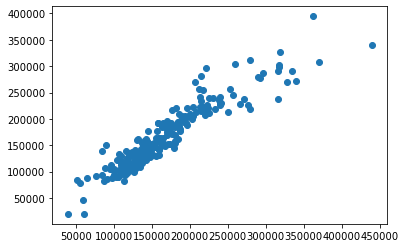

In [37]:
plt.scatter(y_test, y_pred)

#### Refining Features

Our preprocessed dataset has a large number of features, so our first step is going to be to setup a pipeline to refine our linear model and determine the k number of features to use with selectkbest and evaluating based on a simple linear regression. Missing data has already been taken care of and our data is scaled so we will just be using SelectKBest and LinearRegression in our pipeline.

#### SelectKBest pipeline

In [22]:
#Set up pipeline with to refine number of features to 10 (default)
pipe = make_pipeline(
    SelectKBest(f_regression),
    LinearRegression()
)

In [23]:
#fitting pipeline to training data
pipe.fit(X_train, y_train)

C:\Users\nicho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x000001FD13938C10>)),
                ('linearregression', LinearRegression())])

In [24]:
#making predictions on our test data
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [25]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.8271936347884064, 0.8318934027758689)

In [26]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(18762.683648017406, 18759.813511175136)

In [27]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(718314939.4266839, 659757650.636209)

### Feature Selection

In [28]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'linearregression', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [29]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [30]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [31]:
lr_grid_cv.fit(X_train, y_train)

C:\Users\nicho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001FD13938C10>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [32]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [33]:
lr_grid_cv.best_params_

{'selectkbest__k': 162}

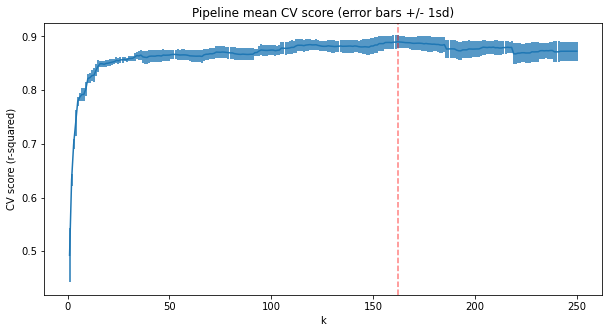

In [48]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [46]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [50]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

SaleType_Con             73752.656271
SaleType_CWD             51925.357700
Neighborhood_StoneBr     49970.654340
SaleType_New             44712.823436
BsmtCond_Gd              36791.083686
Neighborhood_Crawfor     36354.680896
BsmtCond_TA              33313.560978
Neighborhood_NridgHt     27429.399807
ExterQual_Ex             26668.232252
BsmtCond_Fa              25784.170180
Neighborhood_NoRidge     23907.549886
Foundation_CBlock        23169.402582
Foundation_Slab          22995.067613
Neighborhood_BrDale      22422.181922
Foundation_PConc         22003.515884
Foundation_BrkTil        20806.102915
Heating_Wall             20705.697984
KitchenQual_Ex           18620.412004
BldgType_1Fam            18460.091599
Neighborhood_Somerst     16765.841127
Functional_Typ           15910.205368
BsmtExposure_Gd          15310.848523
GarageQual_TA            14522.442614
Neighborhood_BrkSide     13265.713465
BsmtQual_Ex              11953.295024
SaleCondition_Normal     10905.297032
MSZoning_FV 

## Random Forest Model

### Make Pipeline

In [55]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor()
)

### Fit and assess using CV

In [56]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [57]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.85977445, 0.89270933, 0.85911845, 0.86141231, 0.87038681])

In [58]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.8686802678704627, 0.012679695618585986)

### GridsearchCV

In [63]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [64]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [65]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [66]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 143,
 'standardscaler': StandardScaler()}

In [67]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.86049182, 0.89488743, 0.86106857, 0.86057741, 0.86777723])

In [68]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.8689604927126137, 0.013250531511326137)

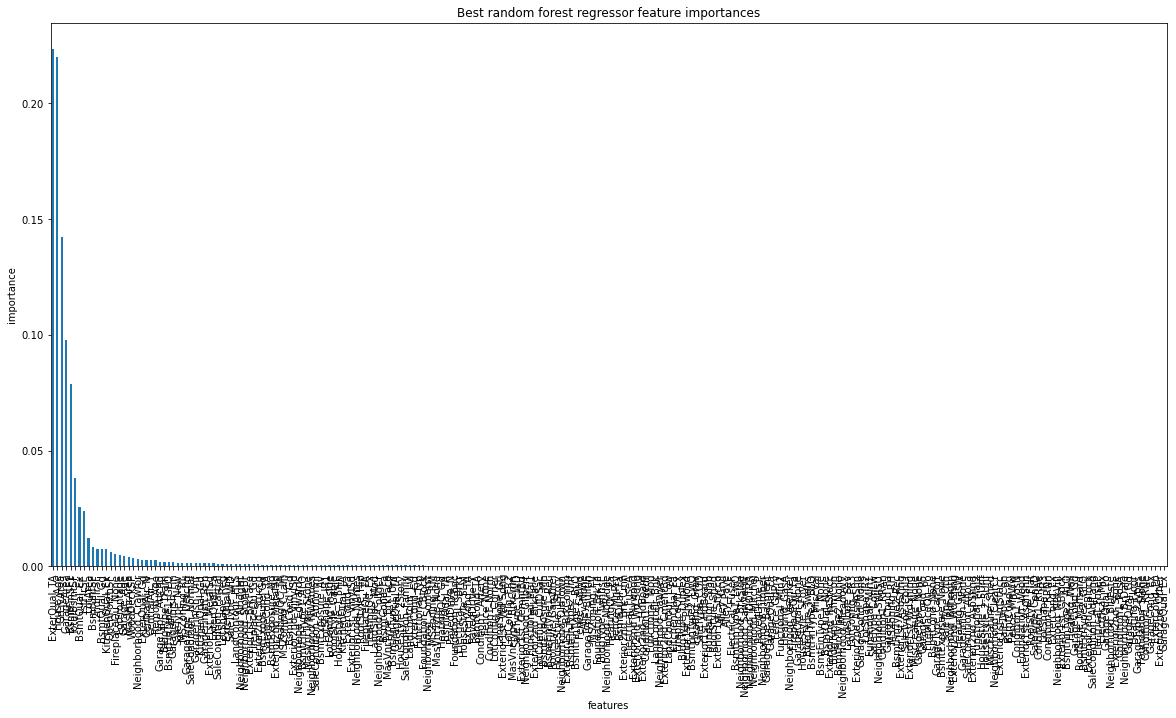

In [70]:
plt.subplots(figsize=(20, 10))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [71]:
rf_feat_imps

ExterQual_TA             2.236243e-01
House_Age                2.199100e-01
GrLivArea                1.423308e-01
GarageArea               9.760439e-02
BsmtFinSF1               7.895726e-02
TotalBsmtSF              3.825483e-02
BsmtQual_Ex              2.551512e-02
1stFlrSF                 2.402492e-02
LotArea                  1.242676e-02
BsmtUnfSF                8.489297e-03
2ndFlrSF                 7.574921e-03
BsmtQual_Gd              7.558478e-03
KitchenQual_Ex           7.500636e-03
OpenPorchSF              5.971904e-03
FireplaceQu_None         5.345303e-03
LotFrontage              4.767409e-03
Garage_Age               4.426686e-03
MasVnrArea               3.833109e-03
WoodDeckSF               3.648181e-03
Neighborhood_Crawfor     3.012849e-03
ExterQual_Gd             2.842026e-03
CentralAir_N             2.818202e-03
CentralAir_Y             2.737972e-03
Remod_Age                2.647082e-03
GarageType_Attchd        2.012368e-03
BldgType_1Fam            1.947302e-03
BsmtFinType1

Top features according to RF model:
- Exterior Quality
- House Age
- General Living Area Square Footage
- Garage Area
- Basement finished square footage
- Total Basement Square Footage
- Basement Quality
- Lot Area

I think we can noorow down our parameters to the above to simplify our model. 1stflrSF and 2ndflrSF are both import as well, but they are a bit redundant as they are included in GRLivArea. There are several other related and semi-redundant features as well, such as lot area and lot frontage, TotalBsmtSF and BsmtFinSF, etc, so we will just pick the ones with higher importance. 

## Lasso Regression Model

In [73]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.4, normalize=True)
lasso.fit(X_train,y_train)

Lasso(alpha=0.4, normalize=True)

In [74]:
df_vars=df.drop('SalePrice',axis=1)
colnames = df_vars.columns

In [75]:
lasso_coef = lasso.coef_
pd.Series(lasso_coef, index=colnames).sort_values(ascending=False)

RoofStyle_Shed           8.121948e+04
SaleType_Con             7.528876e+04
SaleType_CWD             5.676711e+04
Neighborhood_StoneBr     5.577335e+04
Neighborhood_Crawfor     3.551061e+04
ExterQual_Ex             3.281978e+04
Neighborhood_NPkVill     3.086395e+04
Neighborhood_NridgHt     2.939407e+04
GarageCond_Po            2.450626e+04
BldgType_1Fam            2.413450e+04
Foundation_Stone         2.239346e+04
KitchenQual_Ex           2.205875e+04
ExterCond_Ex             2.156588e+04
Neighborhood_NoRidge     2.149676e+04
Neighborhood_BrDale      2.130520e+04
Condition1_PosA          2.069964e+04
BsmtFinType2_ALQ         2.053798e+04
Neighborhood_Blmngtn     1.829510e+04
Exterior1st_BrkFace      1.741162e+04
Neighborhood_Somerst     1.699572e+04
BsmtQual_Ex              1.610104e+04
BsmtExposure_Gd          1.609275e+04
Exterior1st_MetalSd      1.577970e+04
Condition1_PosN          1.523306e+04
SaleCondition_AdjLand    1.331684e+04
Heating_Wall             1.189153e+04
Exterior2nd_

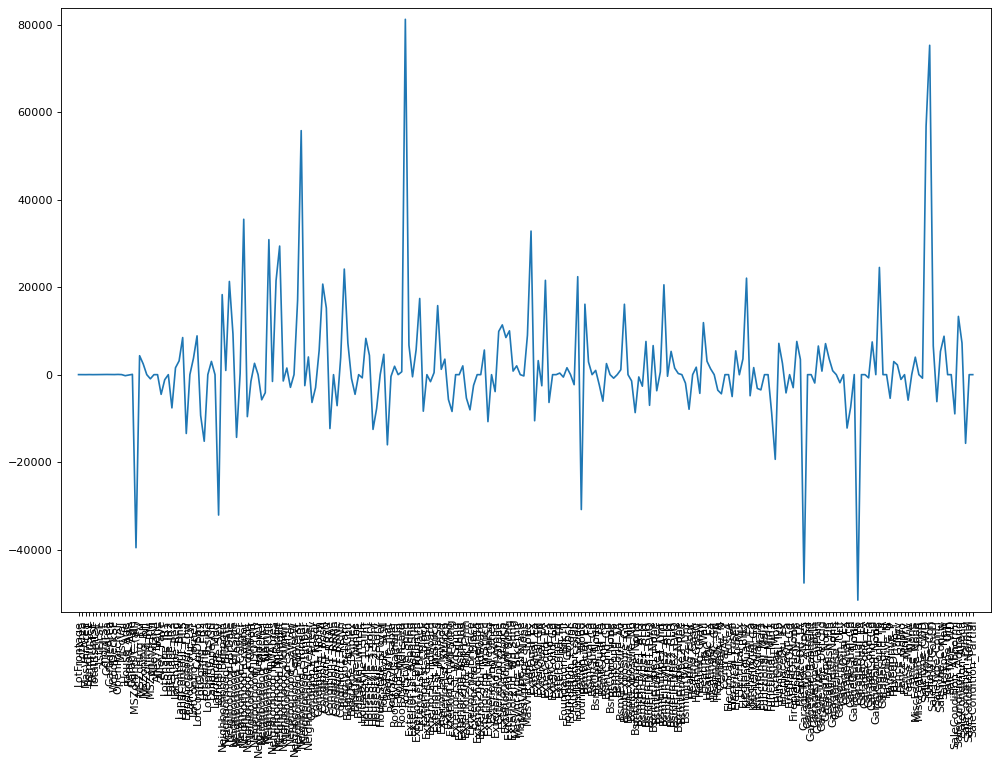

In [76]:
# Plot the coefficients
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=80)
plt.plot(range(len(colnames)), lasso_coef)
plt.xticks(range(len(colnames)), colnames.values, rotation=90) 
plt.margins(0.02)
plt.show()

## Ridge Regression Model

In [77]:
from sklearn.linear_model import Ridge

alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

ridge = Ridge(normalize=True)

In [78]:
for alpha in alpha_space:
    ridge.alpha = alpha
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    ridge_scores.append(np.mean(ridge_cv_scores))
    ridge_scores_std.append(np.std(ridge_cv_scores))

In [79]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()


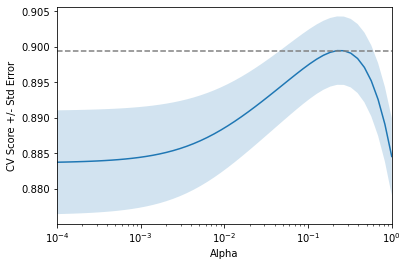

In [80]:
display_plot(ridge_scores, ridge_scores_std)